In [1]:
from Dataset.dataset import Eve, Flchain, Nwtco
import numpy as np
import pandas as pd

from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis

from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import pickle
from model import XSurvKMeansRF
import time
import seaborn as sns
import matplotlib.pyplot as plt



C:\Users\Abd\AppData\Local\conda\conda\envs\hh\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = Nwtco('Dataset/nwtco.csv')

Dataset Description =======================
Dataset Name: Nwtco
Dataset Shape: (4028, 11)
Events: 14.18 %
NaN Values: 0.00 %
Events % in splits: 14.14, 14.14, 14.14, 14.29, 14.16, 



In [3]:
(x_train, ye_train, y_train, e_train,
 x_val, ye_val, y_val, e_val,
 x_test, ye_test, y_test, e_test) = ds.get_train_val_test_from_splits(test_id=0, val_id=1)
 #train_df_orig, val_df_orig, test_df_orig) = ds.get_train_val_test_from_splits(test_id=0, val_id=1)

print('Testing on %d-----------------------------' % 1)
print(x_train.shape, x_val.shape)

Testing on 1-----------------------------
(2416, 9) (806, 9)


In [4]:
ds.features_names

['age',
 'in.subcohort',
 'instit_2',
 'histol_2',
 'study_4',
 'stage_1',
 'stage_2',
 'stage_3',
 'stage_4']

In [5]:
# special for RSF
dt = np.dtype('bool,float')
y_train_surv = np.array([(bool(e), y) for e, y in zip(e_train, y_train)], dtype=dt)
y_val_surv = np.array([(bool(e), y) for e, y in zip(e_val, y_val)], dtype=dt)
y_test_surv = np.array([(bool(e), y) for e, y in zip(e_test, y_test)], dtype=dt)
print(y_train_surv.shape, y_val_surv.shape, y_test_surv.shape)

# # train RSF
# rsf = RandomSurvivalForest(n_estimators=50,
#                            min_samples_split=5,
#                            min_samples_leaf=5,
#                            max_features="sqrt",
#                            oob_score=True,
#                            n_jobs=-1,
#                            random_state=20)
# #rsf.fit(x_train, y_train_surv)

# # special for Cox
# xy_train_df = pd.DataFrame(x_train)
# xy_train_df['T'] = y_train
# xy_train_df['E'] = e_train

# xy_val_df = pd.DataFrame(x_val)
# xy_val_df['T'] = y_val
# xy_val_df['E'] = e_val

# xy_test_df = pd.DataFrame(x_test)
# xy_test_df['T'] = y_test
# xy_test_df['E'] = e_test

# cph = CoxPHFitter(penalizer=500).fit(xy_train_df, 'T', 'E')

cph = CoxPHSurvivalAnalysis(alpha=0.1, n_iter=10000).fit(x_train, y_train_surv)

(2416,) (806,) (806,)


In [6]:
cindex_train = cph.score(x_train, y_train_surv)
cindex_val = cph.score(x_val, y_val_surv)
cindex_test = cph.score(x_test, y_test_surv)

In [7]:
#pickle.dump(rsf, open('rsf_model_eve.mdl', 'wb'))
#rsf = pickle.load(open('rsf_model_eve.mdl', 'rb'))

In [8]:
# cindex_train = rsf.score(x_train, y_train_surv)
# cindex_oob = rsf.oob_score_
# cindex_val = rsf.score(x_val, y_val_surv)
# cindex_val_events = rsf.score(x_val[e_val==1], y_val_surv[e_val==1])

print('Train cindex {:.2f}'.format(cindex_train*100))
print('Val cindex {:.2f}'.format(cindex_val*100))
print('Test cindex {:.2f}'.format(cindex_test*100))

Train cindex 69.44
Val cindex 74.20
Test cindex 75.37


In [9]:
yp = -np.dot(x_train, cph.coef_)
concordance_index(y_train, yp, e_train)

0.6943580044493731

In [10]:
ds.features_names

['age',
 'in.subcohort',
 'instit_2',
 'histol_2',
 'study_4',
 'stage_1',
 'stage_2',
 'stage_3',
 'stage_4']

In [11]:
cph.coef_

array([ 0.19922289, -0.05041882,  0.09638407,  0.37070995, -0.02061398,
       -0.23246413,  0.05345079,  0.07873646,  0.18206089])

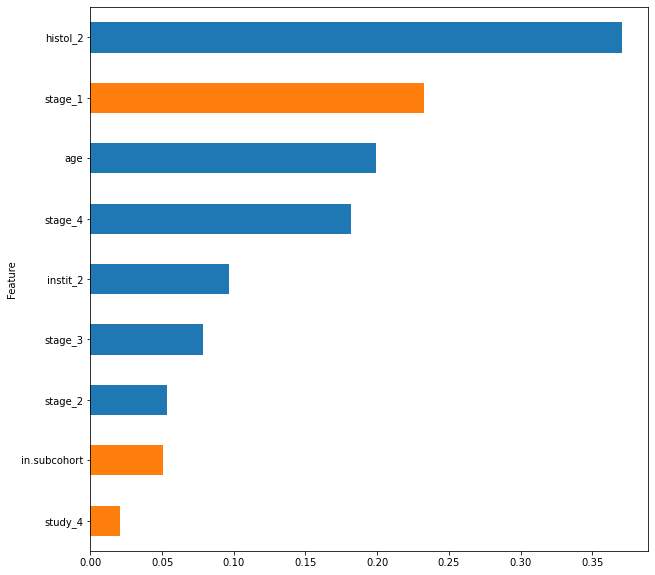

In [12]:
cph_feature_importnce_df = pd.DataFrame(zip(ds.features_names, cph.coef_), columns=['Feature', 'Importance'])
cph_feature_importnce_df.set_index('Feature', inplace=True)

cph_feature_importnce_df['Color'] = cph_feature_importnce_df['Importance'].map(lambda x: 'C0' if x>=0 else 'C1')
cph_feature_importnce_df['Abs_Imp'] = cph_feature_importnce_df['Importance'].abs()

plt.figure(figsize=(10, 10))
cph_feature_importnce_df.sort_values('Abs_Imp')['Abs_Imp'].plot.barh(color=cph_feature_importnce_df.sort_values('Abs_Imp')['Color'])

In [13]:
# special for Cox
xy_train_df = pd.DataFrame(x_train, columns=ds.features_names)
xy_train_df['T'] = y_train
xy_train_df['E'] = e_train

xy_val_df = pd.DataFrame(x_val, columns=ds.features_names)
xy_val_df['T'] = y_val
xy_val_df['E'] = e_val

xy_test_df = pd.DataFrame(x_test, columns=ds.features_names)
xy_test_df['T'] = y_test
xy_test_df['E'] = e_test

cph = CoxPHFitter(penalizer=0.1).fit(xy_train_df, 'T', 'E')


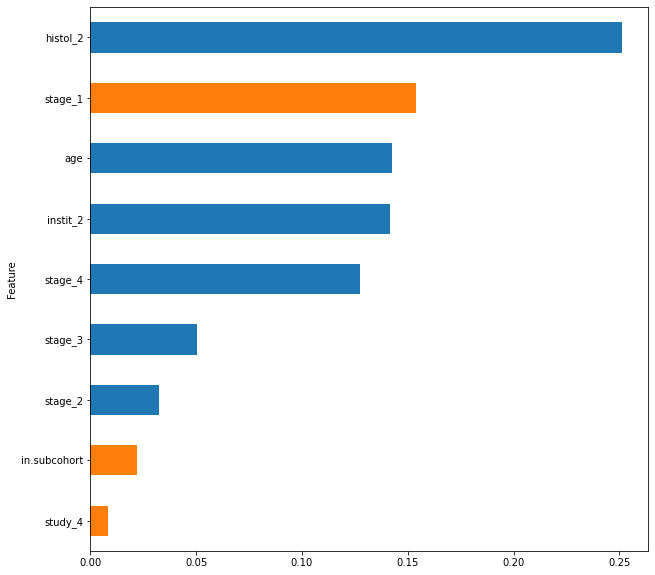

In [14]:
cph_feature_importnce_df = pd.DataFrame(zip(ds.features_names, cph.params_), columns=['Feature', 'Importance'])
cph_feature_importnce_df.set_index('Feature', inplace=True)

cph_feature_importnce_df['Color'] = cph_feature_importnce_df['Importance'].map(lambda x: 'C0' if x>=0 else 'C1')
cph_feature_importnce_df['Abs_Imp'] = cph_feature_importnce_df['Importance'].abs()

plt.figure(figsize=(10, 10))
cph_feature_importnce_df.sort_values('Abs_Imp')['Abs_Imp'].plot.barh(color=cph_feature_importnce_df.sort_values('Abs_Imp')['Color'])

In [15]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 2416 total observations, 2073 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 2416
number of events observed = 343
   partial log-likelihood = -2554.47
         time fit was run = 2022-05-19 12:33:37 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
age            0.14       1.15       0.04             0.06             0.22                 1.07                 1.25
in.subcohort  -0.02       0.98       0.04            -0.10             0.06                 0.90                 1.06
instit_2       0.14       1.15       0.04             0.06             0.22                 1.07                 1.25
histol_2       0.25       1.29       0.04             0.17             0.33                 1.19                 1.39
study_4       -0.01       0.99       0.04            -0.09             0.07                 0.91                 1.08
stage_1       -0.15       0.86       0.05            -0.25            -0.06                 0.78                 0.94
stage_2        0.03       1.03       0.05            -0.06             0.12                 0.94                 1.13
stage_3        0.05       1.05       0.05            -0.04             0.14                 0.96                 1.15
stage_4        0.13       1.14       0.04             0.05             0.21                 1.05                 1.23
                 z      p   -log2(p)
covariate                           
age           3.59 <0.005      11.55
in.subcohort -0.54   0.59       0.76
instit_2      3.55 <0.005      11.34
histol_2      6.18 <0.005      30.56
study_4      -0.20   0.84       0.25
stage_1      -3.14 <0.005       9.20
stage_2       0.70   0.48       1.05
stage_3       1.12   0.26       1.92
stage_4       3.12 <0.005       9.13
---
Concordance = 0.70
Partial AIC = 5126.95
log-likelihood ratio test = 148.74 on 9 df
-log2(p) of ll-ratio test = 89.01

In [16]:
surv_train = cph.predict_survival_function(x_train)
event_times = np.array(surv_train.index) #cph.baseline_survival_.x

surv_train = surv_train.values.transpose() #np.array([s.y for s in surv_train])

surv_val = cph.predict_survival_function(x_val).values.transpose()
#surv_val = np.array([s.y for s in surv_val])

surv_test = cph.predict_survival_function(x_test).values.transpose()
#surv_test = np.array([s.y for s in surv_test])



#Explanation
xte_data = (x_train, y_train, e_train,
            x_val, y_val, e_val,
            x_test, y_test, e_test)

survival_curves = (surv_train, surv_val, surv_test)

In [17]:
# surv_train = cph.predict_survival_function(x_train)
# surv_train = np.array([s.y for s in surv_train])

# surv_val = cph.predict_survival_function(x_val)
# surv_val = np.array([s.y for s in surv_val])

# surv_test = cph.predict_survival_function(x_test)
# surv_test = np.array([s.y for s in surv_test])

# event_times = cph.baseline_survival_.x

# #Explanation
# xte_data = (x_train, y_train, e_train,
#             x_val, y_val, e_val,
#             x_test, y_test, e_test)

# survival_curves = (surv_train, surv_val, surv_test)

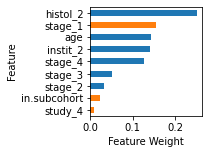

In [18]:
plt.figure(figsize=(2, 2))
cph_feature_importnce_df.sort_values('Abs_Imp')['Abs_Imp'].plot.barh(color=cph_feature_importnce_df.sort_values('Abs_Imp')['Color'])
plt.xlabel('Feature Weight')
plt.savefig('Results/nwtco_cph/nwtco_cph_w.pdf', format='pdf', bbox_inches='tight')

shape: 1909


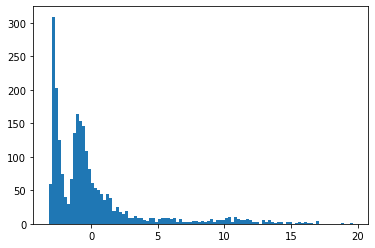

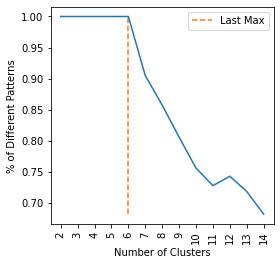

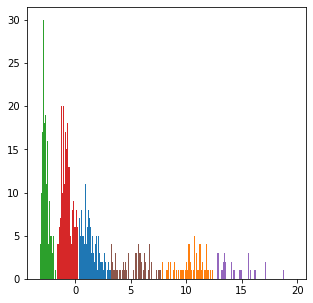

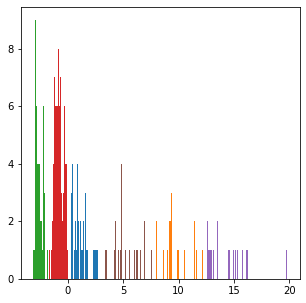

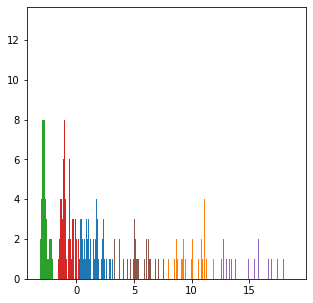

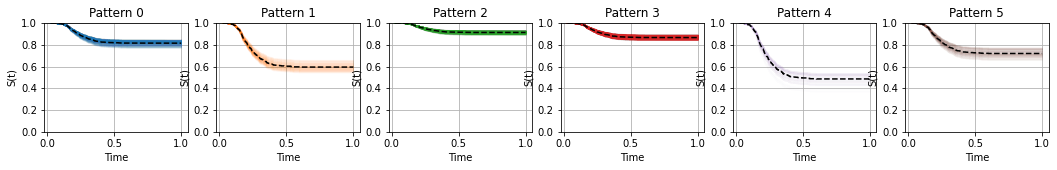

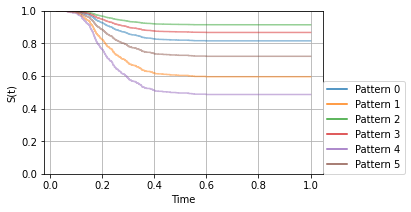

In [19]:
explainer = XSurvKMeansRF(prefix_name='nwtco_cph', max_k=15, z_explained_variance_ratio_threshold=0.99, curves_diff_significance_level=0.05)
explainer.fit(xte_data=xte_data, survival_curves=survival_curves, event_times=event_times)#, pretrained_clustering_model="clustering_model_eve_9_20220223-152051.mdl", k=9)

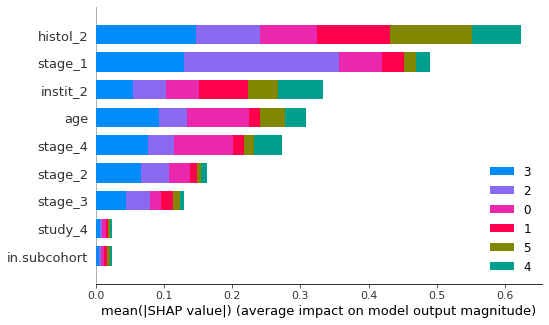

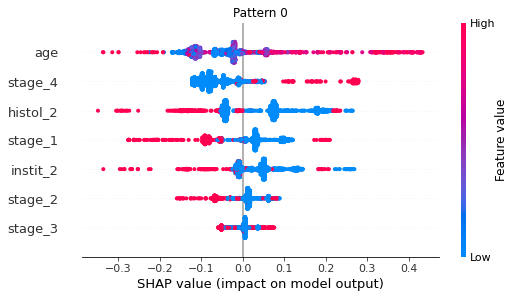

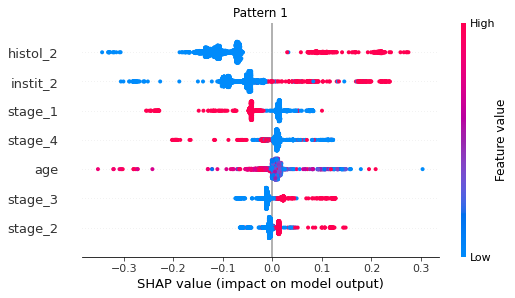

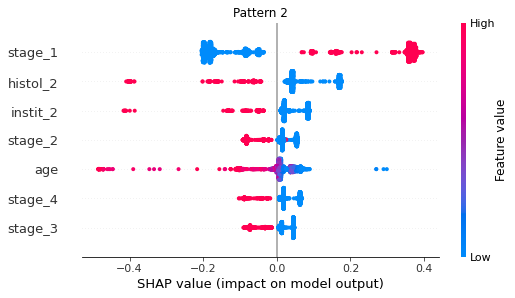

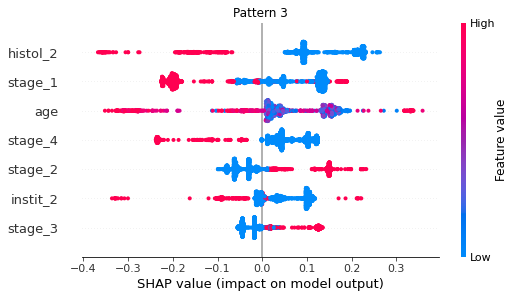

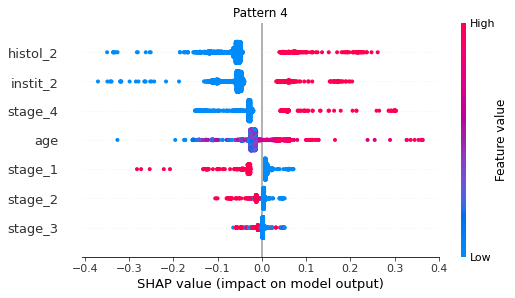

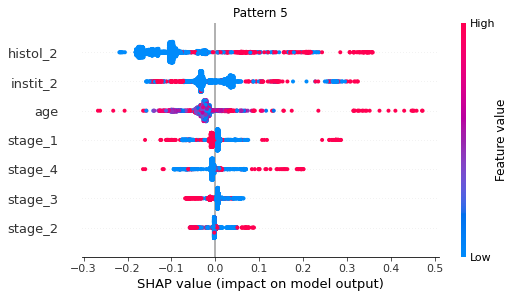

In [20]:
shap_values_train = explainer.explain(x=x_train, features_names_list=ds.features_names, suffex='train')

In [21]:
#shap_values_val = explainer.explain(x=x_val, features_names_list=ds.features_names, suffex='val')

In [22]:
#shap_values_test = explainer.explain(x=x_test, features_names_list=ds.features_names, suffex='test')